# Customer Churn Prediction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
data = pd.read_json("challenge.json").dropna()

data.head()

,branch_id,customer_code,group_code,is_churn,item_code,item_total_price,order_id,quantity,register_date,sales_channel,segment_code,seller_code,total_price,unit_price
0,0,143,0,0.0,854,292.91,21804,10,2017-11-10T00:00:00Z,0,0,190,1613.53,25.04
1,0,433,0,0.0,246,287.19,5486,20,2011-05-16T00:00:00Z,1,5,153,11163.69,12.33
2,0,486,0,0.0,1420,184.84,22662,12,2018-01-24T00:00:00Z,0,0,166,6432.12,12.80
3,0,107,0,0.0,1963,189.18,3956,18,2010-07-28T00:00:00Z,1,0,156,831.82,10.51
4,0,768,0,0.0,1786,66.87,4730,5,2010-12-17T00:00:00Z,1,0,218,1736.48,11.82


# Feature engineering


For each customer we extract the following features:

* The order_id of the first order and the associated seller_code.
* The item_code of the last item.
* The mean quantity.
* The mean item_total_price.
* The mean total_price.
* The mean unit_price.

In [4]:
columns = ['customer_code',
           'is_churn',
           'item_code',
           'item_total_price',
           'order_id',
           'quantity',
           'seller_code',
           'total_price',
           'unit_price',
          ]

dic = {'is_churn': 'first',
       'item_code': 'last',
       'item_total_price': 'mean',
       'order_id': 'first',
       'quantity': 'mean',
       'seller_code': 'first',
       'total_price': 'mean',
       'unit_price': 'mean',
      }

df = data[columns]\
    .sort_values(['order_id', 'item_code'])\
    .groupby('customer_code')\
    .agg(dic)

df.head()

,is_churn,item_code,item_total_price,order_id,quantity,seller_code,total_price,unit_price
customer_code,,,,,,,,
0,0.0,2876,471.076369,967,9.307263,153,4389.258436,67.850670
1,0.0,2673,192.872654,199,6.830149,154,2300.680764,54.524862
2,0.0,2862,317.706743,55,10.436482,208,2741.164300,48.270912
3,0.0,1781,604.128283,206,15.943307,134,8035.883764,78.777307
4,0.0,2630,345.650797,190,14.561462,3,3577.577608,39.980399


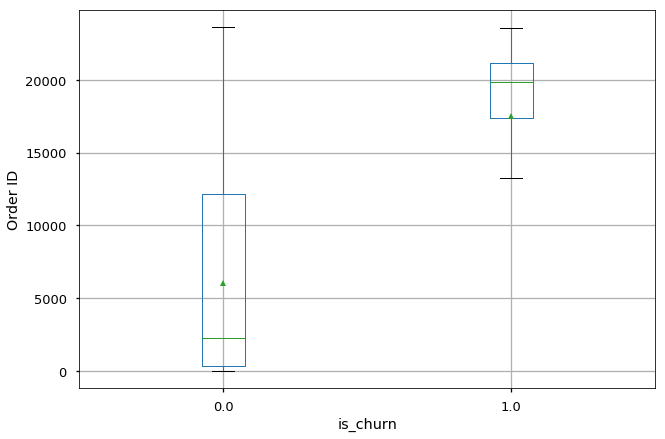

In [5]:
df.boxplot(column='order_id', by='is_churn', showmeans=True, figsize=(10, 7))
plt.suptitle('')
plt.title('')
plt.ylabel('Order ID');

## Null hypothesis

In [6]:
df.is_churn.value_counts()

0.0    737
1.0     81
Name: is_churn, dtype: int64

The null hypothesis states:
- *there are no churn customers*.

The accuracy of the null hypothesis is given by:
- 737 / (737 + 81) = 0.9

The accuracy of the null hypothesis is intrinsically high due the imbalance of the target class in the dataset. 

# Classification Models

- Define target class: **y** 
- Define matrix of features: **X**

In [7]:
y = df.is_churn

X = df.drop("is_churn", axis=1)

## Logistic Regression

In [8]:
clf = LogisticRegression(solver='liblinear')

scores = cross_val_score(clf, X, y, cv=3)

acc0 = round(np.mean(scores), 3)

print("Mean accuracy Logistic Regression without feature scaling:", acc0)

Mean accuracy Logistic Regression without feature scaling: 0.91


In [9]:
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

scores = cross_val_score(clf, X, y, cv=3)

acc1 = round(np.mean(scores), 3)

print("Mean accuracy Logistic Regression with feature scaling:", acc1)

Mean accuracy Logistic Regression with feature scaling: 0.933


## Random Forest

In [10]:
clf = RandomForestClassifier(
    n_estimators=10,
    random_state=42,
    class_weight='balanced_subsample')

scores = cross_val_score(clf, X, y, cv=3)

acc2 = round(np.mean(scores), 3)

print("Mean accuracy Ramdom Forest without feature scaling:", acc2)

Mean accuracy Ramdom Forest without feature scaling: 0.894


In [11]:
clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=10,
        random_state=42,
        class_weight='balanced_subsample')
)

scores = cross_val_score(clf, X, y, cv=3)

acc3 = round(np.mean(scores), 3)

print("Mean accuracy Ramdom Forest with feature scaling:", acc3)

Mean accuracy Ramdom Forest with feature scaling: 0.894


# Summary

In [12]:
results = pd.DataFrame({
    "model": ["LogisticRegression", "RandomForest"],
    "with_feature_scaling": [acc1, acc3],
    "wout_feature_scaling": [acc0, acc2],
}).set_index("model")

results

,with_feature_scaling,wout_feature_scaling
model,,
LogisticRegression,0.933,0.910
RandomForest,0.894,0.894


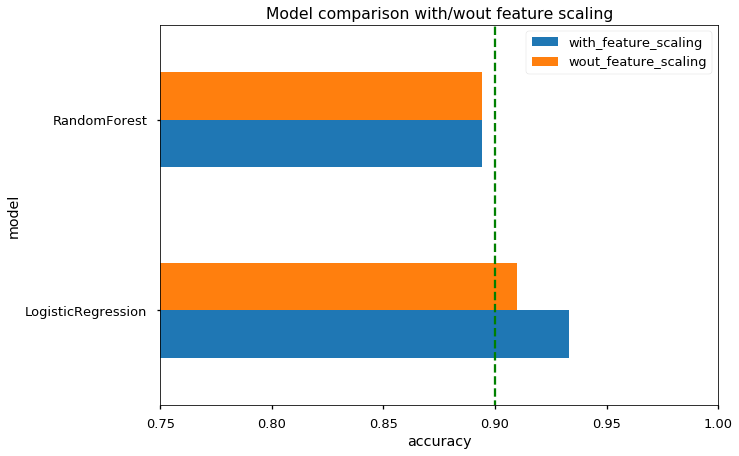

In [13]:
ax = results.plot.barh(figsize=(10, 7))
ax.set_title("Model comparison with/wout feature scaling")
ax.set_xlabel("accuracy")
ax.set_xlim(0.75, 1)

plt.plot([0.9, 0.9], [-1, 2], 'g--'); # null hypothesis

## Conclusion

The logisitic regression model with feature scaling presents the best performance in terms of classification accuracy. In contrast, the random forest model is worse than the null hypothesis.